# Overparameterization of deep ResNet: zero loss and mean-field analysis
## Ding, Chen, Li, Wright 2021

In [1]:
import matplotlib.pyplot as plt
import torch
from torchtyping import TensorType
from typing import Literal
import random

### Hyperparameters

In [2]:
D = 5
K = 2*D + 1
M = 10
MAX_LOG_L = 10
MAX_L = 2**MAX_LOG_L

In [3]:
device = torch.device("cuda")

### Parameters

In [74]:
def init_params(style: Literal["gaussian", "wiener", "zeros"]):
    gaussian = torch.normal(0,1,size=(M,MAX_L,K), device=device)
    wiener = torch.cumsum(gaussian, axis=1)/MAX_L
    zeros = torch.zeros(M,MAX_L,K, device=device)
    if style == "gaussian":
        theta = gaussian
    elif style == "wiener":
        theta = wiener
    elif style == "zeros":
        theta = zeros
    theta.requires_grad = True
    # theta_untrained = theta.clone().detach()
    return theta
theta = init_params("gaussian")
del theta

### Before training

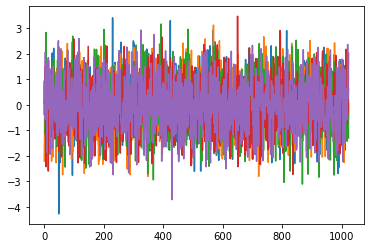

In [77]:
def plot_some_params(theta):
    plt.plot(theta[0,:,[0,1,2,3,4]].detach().cpu())
    plt.show()
plot_some_params(init_params("gaussian"))

### Neural network modeled after (4)

#### Derivatives

In [68]:
def f(z: TensorType["b", "d"], theta: TensorType["k"]):
    W, U, b = theta[:D], theta[D:2*D], theta[2*D]
    return torch.einsum("d, b -> b d", U, torch.relu(torch.einsum("d, b d -> b", W, z) + b))

def F_slow(z: TensorType["b", "d"], t: int, theta: TensorType["m", "l", "k"]):
    return sum(f(z, theta[m, t]) for m in range(M))/M

In [69]:
def F_vectorized(z: TensorType["b", "d"], t: int, theta: TensorType["m", "l", "k"]):
    W, U, b = theta[:, t, :D], theta[:, t, D:2*D], theta[:, t, 2*D]
    return torch.einsum("m d, b m -> b d", U, torch.relu(torch.einsum("m d, b d -> b m", W, z) + b))

#### Forward pass

In [8]:
RESNET = True

In [78]:
def z_recursive(l: int, LOG_L: int, x: TensorType["b", "d"], theta: TensorType["m", "l", "k"]):
    if l == 0:
        return x
    else:
        prev_z = z_recursive(l-1, L, x)
        if RESNET:
            return prev_z + F(prev_z, i*2**(MAX_LOG_L-LOG_L), theta)/2**LOG_L
        else:
            return F(prev_z, i*2**(MAX_LOG_L-LOG_L), theta)/2**LOG_L

In [80]:
def z_iterative(l: int, LOG_L: int, x: TensorType["b", "d"], theta: TensorType["m", "l", "k"]):
    z = x
    for i in range(l):
        if RESNET:
            z = z + F_vectorized(z, i*2**(MAX_LOG_L-LOG_L), theta)/2**LOG_L 
        else:
            z = F_vectorized(z, i*2**(MAX_LOG_L-LOG_L), theta)/2**LOG_L 
    return z

In [81]:
def z(LOG_L: int, x: TensorType["b", "d"], theta: TensorType["m", "l", "k"]):
    return z_iterative(2**LOG_L, LOG_L, x, theta)

### Batch size and data

In [82]:
B = 100
x_generator = lambda: torch.normal(0,1,size=(B,D),device=device)
x = x_generator()

### Target functions

In [83]:
objectives = dict(
    y1 = lambda x: 1/(x+5),
    y2 = lambda x: x**3,
    y3 = lambda x: torch.sort(x, axis=1).values
)
OBJECTIVE = "y1"

### Training on Gaussian

In [110]:
STOCHASTIC = False
def train(theta: TensorType["m", "l", "k"], lr=1000, iters=20):
    for i in range(iters):
        theta.grad = None
        x_ = x if not STOCHASTIC else x_generator()
        y = z(MAX_LOG_L, x_, theta)
        loss = torch.nn.functional.mse_loss(y, objectives[OBJECTIVE](x_))
        print(f"Epoch {i:>2}: {loss.item():.5f}")
        loss.backward()
        with torch.no_grad():
            theta -= lr*theta.grad
    return theta

In [106]:
theta1 = init_params("gaussian")
theta1_untrained = theta1.clone().detach()
theta1_trained = train(theta1, lr=2000, iters=20)

Epoch  0: 1.30771
Epoch  1: 0.39426
Epoch  2: 0.13856
Epoch  3: 0.01645
Epoch  4: 0.00587
Epoch  5: 0.00394
Epoch  6: 0.00363
Epoch  7: 0.00356
Epoch  8: 0.00353
Epoch  9: 0.00350
Epoch 10: 0.00348
Epoch 11: 0.00347
Epoch 12: 0.00345
Epoch 13: 0.00343
Epoch 14: 0.00342
Epoch 15: 0.00341
Epoch 16: 0.00339
Epoch 17: 0.00338
Epoch 18: 0.00337
Epoch 19: 0.00336


In [89]:
def plot_approximation_curve(theta: TensorType["m", "l", "k"]):
    Zs = [z(l,x,theta) for l in range(MAX_LOG_L)]
    plt.plot([torch.nn.functional.mse_loss(y, objectives[OBJECTIVE](x)).item() for y in Zs])
    plt.show()
    plt.plot(range(4, len(Zs)), [torch.nn.functional.mse_loss(y, objectives[OBJECTIVE](x)).item() for y in Zs[4:]])
    plt.show()
    #plt.plot([[torch.linalg.norm(Zs[i][k]-Zs[i-1][k]).item() for k in range(B)] for i in range(1,len(Zs))])
    #plt.show()

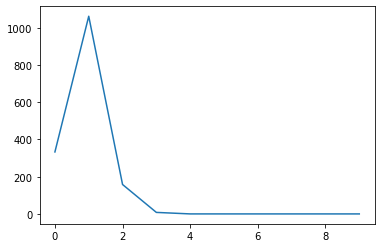

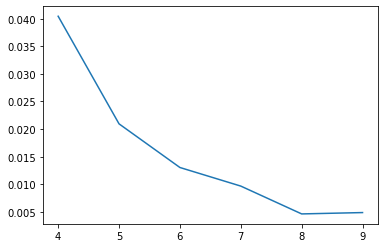

In [91]:
plot_approximation_curve(theta1)

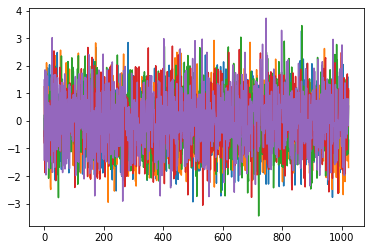

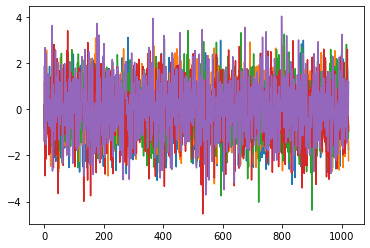

(None, None)

In [94]:
plot_some_params(theta1_untrained), plot_some_params(theta1_trained)

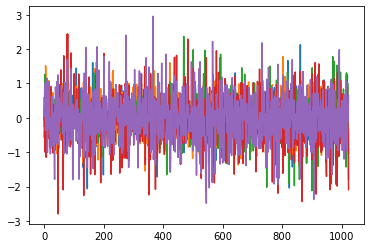

In [95]:
plot_some_params(theta1_trained-theta1_untrained)

### Training on continuous parameters

In [111]:
theta2 = init_params("wiener")
theta2_untrained = theta2.clone().detach()
theta2_trained = train(theta2, lr=4000, iters=20)

Epoch  0: 1.26249
Epoch  1: 1.24530
Epoch  2: 1.15031
Epoch  3: 0.81944
Epoch  4: 0.53856
Epoch  5: 0.28070
Epoch  6: 0.14147
Epoch  7: 0.08603
Epoch  8: 0.08796
Epoch  9: 0.11555
Epoch 10: 0.04779
Epoch 11: 0.02325
Epoch 12: 0.01809
Epoch 13: 0.01551
Epoch 14: 0.01377
Epoch 15: 0.01253
Epoch 16: 0.01158
Epoch 17: 0.01082
Epoch 18: 0.01019
Epoch 19: 0.00967


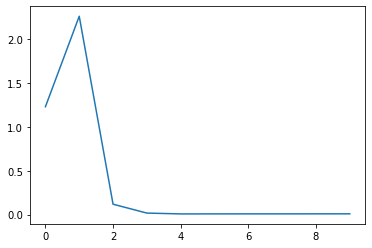

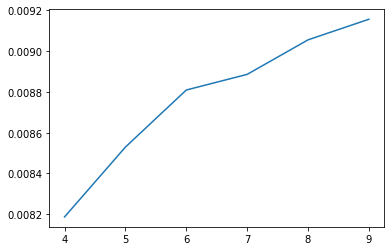

In [114]:
plot_approximation_curve(theta2)

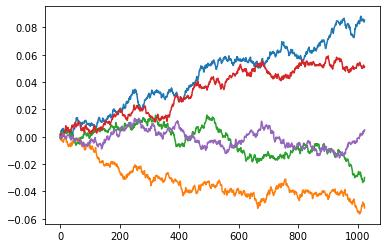

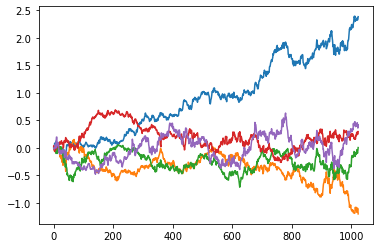

(None, None)

In [115]:
plot_some_params(theta2_untrained), plot_some_params(theta2_trained)

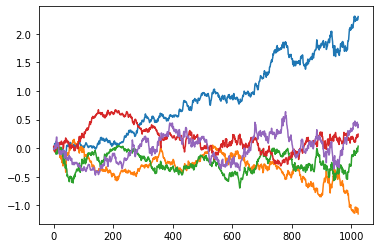

In [116]:
plot_some_params(theta2_trained-theta2_untrained)

### Do only the final layers matter?

In [117]:
first_quarter = z_iterative(MAX_L//4, MAX_LOG_L, x, theta1_trained)
second_quarter = z_iterative(MAX_L//2, MAX_LOG_L, x, theta1_trained)
third_quarter = z_iterative(MAX_L//4*3, MAX_LOG_L, x, theta1_trained)
final_output = z_iterative(MAX_L, MAX_LOG_L, x, theta1_trained)

In [118]:
torch.trace(torch.cdist(x, first_quarter)).item()/B

1.8209722900390626

In [119]:
torch.trace(torch.cdist(first_quarter, second_quarter)).item()/B

0.4715882873535156

In [120]:
torch.trace(torch.cdist(second_quarter, third_quarter)).item()/B

0.2324319839477539

In [121]:
torch.trace(torch.cdist(third_quarter, final_output)).item()/B

0.5793753051757813

In [122]:
torch.trace(torch.cdist(x, final_output)).item()/B

2.297121734619141

In [123]:
first_quarter = z_iterative(MAX_L//4, MAX_LOG_L, x, theta1_untrained)
second_quarter = z_iterative(MAX_L//2, MAX_LOG_L, x, theta1_untrained)
third_quarter = z_iterative(MAX_L//4*3, MAX_LOG_L, x, theta1_untrained)
final_output = z_iterative(MAX_L, MAX_LOG_L, x, theta1_untrained)

In [124]:
torch.trace(torch.cdist(x, first_quarter)).item()/B

0.17196826934814452

In [125]:
torch.trace(torch.cdist(first_quarter, second_quarter)).item()/B

0.17653133392333983

In [126]:
torch.trace(torch.cdist(third_quarter, final_output)).item()/B

0.17522197723388672

In [127]:
torch.trace(torch.cdist(x, final_output)).item()/B

0.3265595245361328

In [139]:
def z_fake_first_quarter(x: TensorType["b", "d"], theta: TensorType["m", "l", "k"]):
    z = x
    L = 2**(MAX_LOG_L-2)
    for i in range(L):
        if RESNET:
            z = z + F_vectorized(z, i, theta)/L 
        else:
            z = F_vectorized(z, i, theta)/L
    return z
def z_fake_final_quarter(x: TensorType["b", "d"], theta: TensorType["m", "l", "k"]):
    z = x
    L = 2**(MAX_LOG_L-2)
    for i in range(L):
        if RESNET:
            z = z + F_vectorized(z, L*3+i, theta)/L
        else:
            z = F_vectorized(z, L*3+i, theta)/L 
    return z

In [206]:
torch.nn.functional.mse_loss(z_fake_first_quarter(x, theta1), objectives[OBJECTIVE](x)).item()

0.049504902213811874

In [205]:
torch.nn.functional.mse_loss(z_fake_final_quarter(x, theta1), objectives[OBJECTIVE](x)).item()

0.02599583938717842

In [204]:
torch.nn.functional.mse_loss(z(MAX_LOG_L-2, x, theta1), objectives[OBJECTIVE](x)).item()

0.007248113863170147

### Solve it using Runge-Kutta

In [149]:
def z_rk4(theta: TensorType["m", "l", "k"], x: TensorType["b", "d"], log_dl: int = 1):
    z = x
    dl = 2**log_dl
    dt = dl/(2**MAX_LOG_L)
    for i in range(2**(MAX_LOG_L-log_dl)):
        t = i*dl
        k1 = F_vectorized(z, t, theta)
        k2 = F_vectorized(z+k1*dt/2, t+dl//2, theta)
        k3 = F_vectorized(z+k2*dt/2, t+dl//2, theta)
        if t+dl < 2**MAX_LOG_L:
            k4 = F_vectorized(z+k3*dt, t+dl, theta)
        else:
            k4 = F_vectorized(z+k3*dt, 2**MAX_LOG_L-1, theta)
        z = z+dt/6*(k1+2*k2+2*k3+k4)
    return z

#### Approximation error

In [160]:
torch.nn.functional.mse_loss(z_rk4(theta1, x, log_dl=3), z(MAX_LOG_L,x, theta1)).item()

0.002795850858092308

In [159]:
torch.nn.functional.mse_loss(z(MAX_LOG_L-1,x,theta1), z(MAX_LOG_L,x, theta1)).item()

0.001092690508812666

#### Does it generalize?

In [187]:
def generalization(theta):
    x_ = x_generator()
    rk1 = torch.nn.functional.mse_loss(z_rk4(theta, x_, log_dl=1), objectives[OBJECTIVE](x_)).item()
    rk2 = torch.nn.functional.mse_loss(z_rk4(theta, x_, log_dl=2), objectives[OBJECTIVE](x_)).item()
    rk3 = torch.nn.functional.mse_loss(z_rk4(theta, x_, log_dl=3), objectives[OBJECTIVE](x_)).item()
    euler1 = torch.nn.functional.mse_loss(z(MAX_LOG_L,x_,theta), objectives[OBJECTIVE](x_)).item()
    euler2 = torch.nn.functional.mse_loss(z(MAX_LOG_L-1,x_,theta), objectives[OBJECTIVE](x_)).item()
    euler3 = torch.nn.functional.mse_loss(z(MAX_LOG_L-2,x_,theta), objectives[OBJECTIVE](x_)).item()
    print(f"Runge-Kutta step-size 2: {rk1:.5f}")
    print(f"Runge-Kutta step-size 4: {rk2:.5f}")
    print(f"Runge-Kutta step-size 8: {rk3:.5f}")
    print(f"Euler step-size 1: {euler1:.5f}")
    print(f"Euler step-size 2: {euler2:.5f}")
    print(f"Euler step-size 4: {euler3:.5f}")

In [188]:
generalization(theta1)

Runge-Kutta step-size 2: 0.00342
Runge-Kutta step-size 4: 0.00364
Runge-Kutta step-size 8: 0.00563
Euler step-size 1: 0.00317
Euler step-size 2: 0.00394
Euler step-size 4: 0.00656


In [189]:
generalization(theta2)

Runge-Kutta step-size 2: 0.01159
Runge-Kutta step-size 4: 0.01154
Runge-Kutta step-size 8: 0.01156
Euler step-size 1: 0.01155
Euler step-size 2: 0.01149
Euler step-size 4: 0.01145


In [166]:
%timeit z(MAX_LOG_L-1, x,theta1)

112 ms ± 358 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [165]:
%timeit z_rk4(theta1,x, log_dl=1)

526 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [164]:
%timeit z(MAX_LOG_L, x,theta1)

230 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Train through Runge-Kutta

In [172]:
STOCHASTIC = False
def train_rk4(theta,lr: float =1000, iters: int =20, correction: bool = False):
    for i in range(iters):
        theta.grad = None
        x_ = x if not STOCHASTIC else x_generator()
        y = z_rk4(theta,x_, log_dl=1)
        loss = torch.nn.functional.mse_loss(y, objectives[OBJECTIVE](x_))
        print(f"Epoch {i:>2}: {loss.item():.5f}")
        loss.backward()
        with torch.no_grad():
            if correction:
                theta[:,:-1:2,:] -= lr*theta.grad[:,:-1:2,:]
                theta[:,1:-1:2,:] -= lr*theta.grad[:,1:-1:2,:]*torch.norm(theta.grad[:,:-1:2,:])/torch.norm(theta.grad[:,1:-1:2,:])
                theta[:,-1,:] -= lr*theta.grad[:,-1,:]*torch.norm(theta.grad[:,-2,:])/torch.norm(theta.grad[:,-1,:])
            else:
                theta -= lr*theta.grad
    return theta

In [173]:
theta3 = init_params("wiener")
theta3_untrained = theta3.clone().detach()
theta3_trained = train_rk4(theta3, lr=2000, iters=10)

Epoch  0: 1.25999
Epoch  1: 1.25300
Epoch  2: 1.22595
Epoch  3: 1.11362
Epoch  4: 0.90618
Epoch  5: 0.74064
Epoch  6: 0.53781
Epoch  7: 0.35659
Epoch  8: 0.23744
Epoch  9: 0.15606


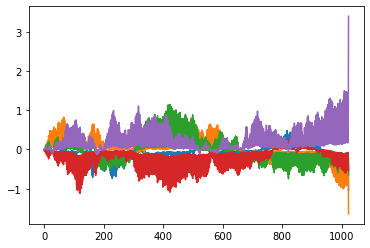

In [174]:
plot_some_params(theta3_trained)

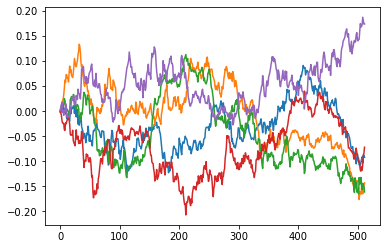

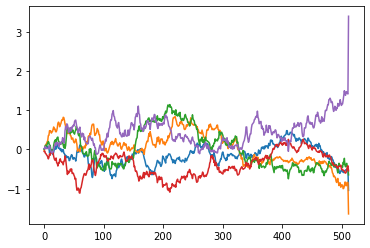

(None, None)

In [176]:
plot_some_params(theta3_trained[:,::2,:]), plot_some_params(theta3_trained[:,1::2,:])

In [177]:
torch.mean(theta3_trained[:,::2,:]/theta3_trained[:,1::2,:]).item()

0.24924173951148987

### Training with rescaled gradient

In [179]:
theta4 = init_params("wiener")
theta4_untrained = theta4.clone().detach()
theta4_trained = train_rk4(theta4, lr=2000, iters=10, correction=True)

Epoch  0: 1.25921
Epoch  1: 1.25246
Epoch  2: 1.23948
Epoch  3: 1.20706
Epoch  4: 1.13485
Epoch  5: 1.02127
Epoch  6: 0.91145
Epoch  7: 0.81822
Epoch  8: 0.72103
Epoch  9: 0.61613


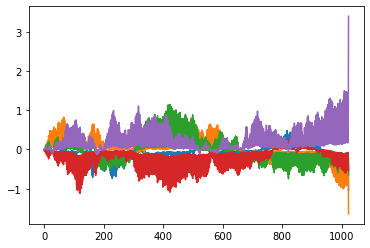

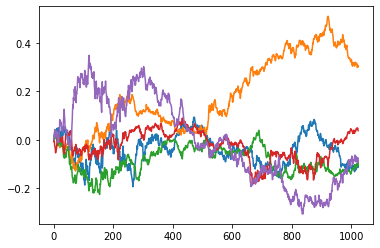

(None, None)

In [195]:
plot_some_params(theta3_trained), plot_some_params(theta4_trained)

## The same for Gaussian

In [182]:
theta5 = init_params("gaussian")
theta5_untrained = theta5.clone().detach()
theta5_trained = train_rk4(theta5, lr=2000, iters=10)

Epoch  0: 1.16482
Epoch  1: 0.46988
Epoch  2: 0.14368
Epoch  3: 0.01796
Epoch  4: 0.00412
Epoch  5: 0.00338
Epoch  6: 0.00332
Epoch  7: 0.00330
Epoch  8: 0.00328
Epoch  9: 0.00327


In [190]:
generalization(theta5)

Runge-Kutta step-size 2: 0.00274
Runge-Kutta step-size 4: 0.02563
Runge-Kutta step-size 8: 0.04111
Euler step-size 1: 0.00362
Euler step-size 2: 0.02653
Euler step-size 4: 0.03203


In [192]:
theta6 = init_params("gaussian")
theta6_untrained = theta6.clone().detach()
theta6_trained = train_rk4(theta6, lr=2000, iters=10, correction=True)

Epoch  0: 1.26341
Epoch  1: 0.41598
Epoch  2: 0.10955
Epoch  3: 0.02253
Epoch  4: 0.00950
Epoch  5: 0.00659
Epoch  6: 0.00578
Epoch  7: 0.00551
Epoch  8: 0.00537
Epoch  9: 0.00527


In [193]:
generalization(theta6)

Runge-Kutta step-size 2: 0.00625
Runge-Kutta step-size 4: 0.00737
Runge-Kutta step-size 8: 0.01124
Euler step-size 1: 0.00620
Euler step-size 2: 0.00756
Euler step-size 4: 0.01146


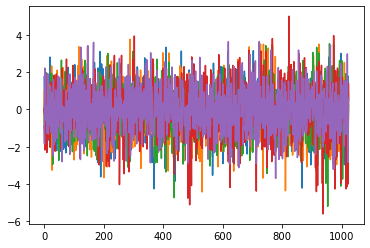

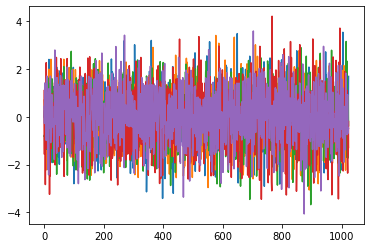

(None, None)

In [194]:
plot_some_params(theta5_trained), plot_some_params(theta6_trained)